#### This notebook demonstrates the use of the learning fair representations algorithm for bias mitigation
Learning fair representations [1] is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes. We will see how to use this algorithm for learning representations that encourage individual fairness and apply them on the Adult dataset.

References:

[1] R. Zemel, Y. Wu, K. Swersky, T. Pitassi, and C. Dwork,  "Learning Fair Representations." 
International Conference on Machine Learning, 2013.

In [3]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.lfr import LFR

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np

from common_utils import compute_metrics

2022-11-02 22:19:56.718801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load dataset and set options

In [5]:
# Get the dataset and split into train and test
dataset_orig = load_preproc_data_adult()
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

#### Clean up training data

In [6]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


#### Metric for original training data

In [7]:
# Metric for the original dataset
privileged_groups = [{'sex': 1.0}]
unprivileged_groups = [{'sex': 0.0}]

metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.192808


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.198500


#### Train with and transform the original training data

In [8]:
scale_orig = StandardScaler()
dataset_orig_train.features = scale_orig.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = scale_orig.transform(dataset_orig_test.features)

In [10]:
# Input recontruction quality - Ax
# Fairness constraint - Az
# Output prediction error - Ay

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
    
TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(dataset_orig_train, maxiter=5000, maxfun=5000)

step: 0, loss: 0.8675884899174469, L_x: 2.529037004850805,  L_y: 0.5909201556562055,  L_z: 0.011882316888080433
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          190     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.67588D-01    |proj g|=  8.08379D-02
step: 250, loss: 0.8362993017393798, L_x: 2.5268481458754026,  L_y: 0.560637286082284,  L_z: 0.011488600534777745

At iterate    1    f=  8.36299D-01    |proj g|=  5.43555D-02
step: 500, loss: 0.8119849174200386, L_x: 2.5166904218681125,  L_y: 0.5402537113364966,  L_z: 0.010031081948365415

At iterate    2    f=  8.11985D-01    |proj g|=  2.07357D-02
step: 750, loss: 0.8059425799706343, L_x: 2.509003494562232,  L_y: 0.5364812052774921,  L_z: 0.009280512618459505

At iterate    3    f=  8.05943D-01    |proj g|=  2.31559D-02

At iterate    4    f=  7.76247D-01    |proj g|=  3.15598D-02
step: 1000, loss: 0.7613713946979381, L_x: 2.3797460199061913,  L_y:

In [11]:
# Transform training data and align features
dataset_transf_train = TR.transform(dataset_orig_train)
dataset_transf_test = TR.transform(dataset_orig_test)

In [12]:
print(classification_report(dataset_orig_test.labels, dataset_transf_test.labels))

              precision    recall  f1-score   support

         0.0       0.80      0.94      0.87     11130
         1.0       0.59      0.27      0.37      3523

    accuracy                           0.78     14653
   macro avg       0.70      0.61      0.62     14653
weighted avg       0.75      0.78      0.75     14653



In [13]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())
metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.009752


#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.005917


In [14]:
from common_utils import compute_metrics

display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []

class_thresh_arr = np.linspace(0.01, 0.99, 100)

dataset_transf_test_new = dataset_orig_test.copy(deepcopy=True)
dataset_transf_test_new.scores = dataset_transf_test.scores


for thresh in class_thresh_arr:
    
    fav_inds = dataset_transf_test_new.scores > thresh
    dataset_transf_test_new.labels[fav_inds] = 1.0
    dataset_transf_test_new.labels[~fav_inds] = 0.0
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_new, 
                                      unprivileged_groups, privileged_groups,
                                      disp = False)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

divide by zero encountered in double_scalars
invalid value encountered in double_scalars


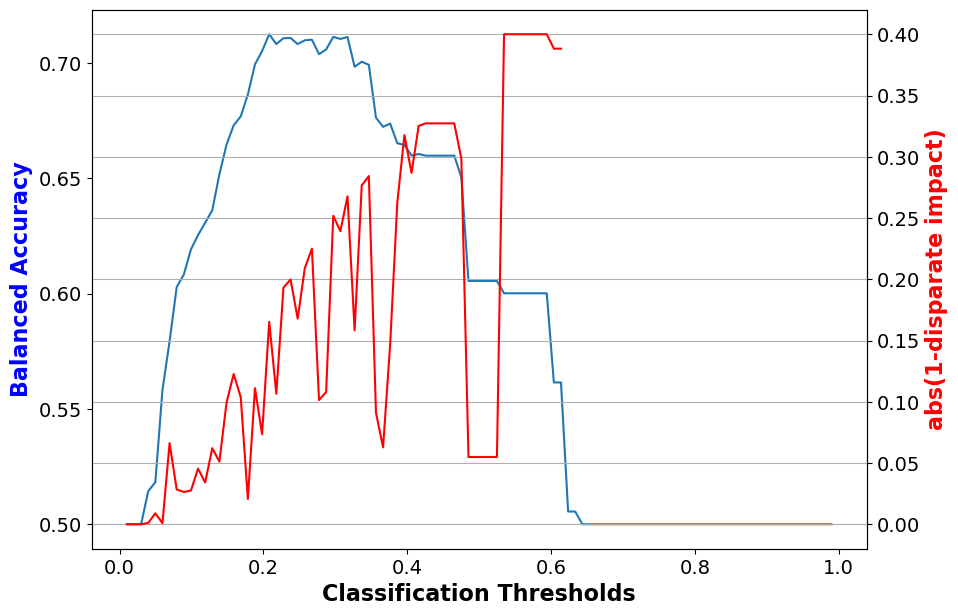

In [15]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

In [16]:
display(Markdown("#### Individual fairness metrics"))
print("Consistency of labels in transformed training dataset= %f" %metric_transf_train.consistency())
print("Consistency of labels in original training dataset= %f" %metric_orig_train.consistency())
print("Consistency of labels in transformed test dataset= %f" %metric_transf_test.consistency())
print("Consistency of labels in original test dataset= %f" %metric_orig_test.consistency())

#### Individual fairness metrics

Consistency of labels in transformed training dataset= 1.000000
Consistency of labels in original training dataset= 0.732692
Consistency of labels in transformed test dataset= 1.000000
Consistency of labels in original test dataset= 0.739603


In [17]:
def check_algorithm_success():
    """Transformed dataset consistency should be greater than original dataset."""
    assert metric_transf_test.consistency() > metric_orig_test.consistency(), "Transformed dataset consistency should be greater than original dataset."

check_algorithm_success()    